# PROJECT WORK
#### 1. Problem Description 

The dataset named Star is obtained from the website http://vincentarelbundock.github.io/Rdatasets/datasets.html. The dataset is a collection of 5748 observations of individual performance in math and reading tests accross 79 different schools. The variables are class sizes, years of teaching experience, gender, qualified for free lunch and race. Below are 5 example instances of the original dataset:

![Data](./Fig/OriginalData.png)


For the scope of this project work, we focus on choosing only one variable and regress math scores based on that variable. The variable chosen here is years of teaching experience. Comparing the original distribution of math scores vs. log-scale of math scores, log-scale math scores seems to follow normal distribution better. Therefore, we choose to build our models with log-scale math scores. 

Data distribution:
![Math](./Fig/Math.png)


#### 2. Model description

In the sections following, we will go through 4 different models:

- Pooled model: all school belongs to the same distribution, log math scores is regressed based on years of teaching experience.  Parameters are beta1, beta2 and sigma that are common for all schools.  
                                        y ~ N(beta1 + beta2*x, sigma) 
- Separate model: each school has its own separate model. The parameters are alpha (unique for each school), beta and sigma (common for all schools)
                                        mu = alpha_school + beta*x
                                        y ~ N(mu, sigma)
- Varying slop and intercept model: each school has its own separate model with both alpha and beta unique for each school, sigma is common for all schools. Alpha and beta follows normal distribution with priors:
                                        mu_alpha ~ N(0,1)
                                        mu_beta ~ N(0,1)
                                        alpha ~ N(mu_alpha, sigma_alpha)
                                        alpha ~ N(mu_alpha, sigma_alpha)
                                        mu = alpha_school + beta_school*x
                                        y ~ N(mu, sigma)
- Hierarchical model: Similar to the varying slope and intercept model but we only use prior for alpha. 
                                        mu_alpha ~ N(0,1)
                                        alpha ~ N(mu_alpha, sigma_alpha)
                                        beta ~ N(0,1)
                                        mu = 
                                        y ~ N(mu, sigma)

For evaluation purpose, we split up training-test data with the corresponding percentage 75-25 to evaluate the accuracy of each models. 

The codes are passed to PyStan and simulated with 2 chains in 1000 iterations. 

#### 2.1. Pooled model 

Stan code:

`data {
    int<lower=0>  N; //Number of train data
    int<lower=0> M; //Number of test data
    vector[N] x; // Variable - teaching experience
    vector[M] x_test; // Test variable 
    vector[N] y; // Labels - log math score
}
parameters {
    vector[2] beta;
    real<lower=0> sigma; //sigma is constrained to be positive 
}
model {
    y ~ normal(beta[1] + beta[2]*x, sigma); 
}
generated quantities{
    vector[N] log_lik;
    vector[M] y_pred_test;
    for (i in 1:M)
     y_pred_test[i] = normal_rng(beta[1] + beta[2]*x_test[i], sigma);
    for (i in 1:N)
     log_lik[i] = normal_lpdf(y[i]| beta[1] + beta[2]*x[i], sigma);
}`

#### 2.2. Separate model 

Stan code

`data{
    int<lower=0> N;
    int<lower=1, upper=79> school[N]; #school indicator
    vector[N] x;
    vector[N] y;
}
parameters {
    vector[79] alpha;
    real beta; 
    real<lower=0> sigma;
}
transformed parameters {
    vector[N] mu;  
    for (i in 1:N)
        mu[i] <- beta* x[i] + alpha[school[i]];
}
model {
    y ~ normal(mu, sigma);
}
generated quantities{
    vector[N] log_lik;
    for (i in 1:N)
     log_lik[i] = normal_lpdf(y[i]| mu[i], sigma);
}`

#### 2.3. Varying intercept and slope model 
Stan code:

    `data {
      int<lower=0> N;
      int<lower=0> J;
      vector[N] y;
      vector[N] x;
      int school[N];
    }
    parameters {
      real<lower=0> sigma;
      real<lower=0> sigma_a;
      real<lower=0> sigma_b;
      vector[J] alpha;
      vector[J] beta;
      real mu_a;
      real mu_b;
    }
    transformed parameters {
        vector[N] mu;  
        for (i in 1:N)
            mu[i] <- alpha[school[i]] + beta[school[i]]*x[i];
    }
    model {
      mu_a ~ normal(0, 1);
      mu_b ~ normal(0, 1);

      alpha ~ normal(mu_a, sigma_a);
      beta ~ normal(mu_b, sigma_b);
      y ~ normal(mu, sigma);
    }

    generated quantities{
        vector[N] log_lik;
        for (i in 1:N)
         log_lik[i] = normal_lpdf(y[i]| mu[i], sigma);
    }`

#### 2.4. Hierarchical model 
Stan code:

#### 3. Convergence and Result
#### 3.1. Pooled model 

R-hat for all variables is approximately 1.0, so we can conclude that the model has converged. Checking effective sample size and divergence returns value True, meaning that there is no problem with the model. The graph below demonstrates the fitted line. 
![Pooledmodel](./Fig/Pooledmodel.png)


#### 3.2. Separate model  
R-hat for all variables is approximately 1.0, so we can conclude that the model has converged. Checking effective sample size and divergence returns value True, meaning that there is no problem with the model.
Alpha (intercept) calculated for different schools:
![Sepmodel_alpha](./Fig/Intercept_separate.png)

#### 3.3. Varying intercept and slope model
R-hat for all variables is approximately 1.0, so we can conclude that the model has converged. Checking effective sample size and divergence returns value True, meaning that there is no problem with the model.
Alpha (intercept) calculated for different schools:
![varymodel_alpha](./Fig/Intercept_varymodel.png)


Beta (slope) calculated for different schools:
![varymodel_beta](./Fig/Slope_Varymodel.png)


#### 3.4. Hierarchical model  



#### 4. Model evaluation with Psis-loo 

Two methods for model evaluation has been used in this project: psis-loo and MAE.

Psisloo results for each model:

| Measurements | Pooled model | Separate model | Varying intercept and slope | Hierarchical model |
| --- | --- | --- | --- | --- |
| psis-loo | 1960.56 | 2176 | 5908 | --- |
| p_eff | 3 | 80 | -3669 | --- |
| k > 0.5 | None | Some | Some | --- |

Scatter plot of ks values for different models:

- Pooled model: all k values is below 0.5. We can conclude that the parameter estimations of the model is reliable

![k_values_pooled](./Fig/k_pooled.png)

- Separate model: some k values is higher than 0.5. The estimates might be biased. 

![k_values_separate](./Fig/k_separate.png)

- Vary slope and intercept model: some k values is higher than 0.5. The estimates might be biased. 

![k_values_vary](./Fig/k_varymodel.png)

- Hierarchical model:

#### 5. Posterior predictive checking  
MAE and MSE results for each model:

| Measurements | Pooled model | Separate model | Varying intercept and slope | Hierarchical model |
| --- | --- | --- | --- | --- |
| MAE | 0.077 | 0.069 | --- | --- |
| MSE| 0.009 | 0.079 | --- | --- |

Posterior distribution:

- Pooled model
- Separate model
- Vary slope and intercept model
- Hierarchical model 

Model comparison: Model .... is most suitable for the dataset because ....

#### 6. Conclusion and potential improvements
In conclusion, it seems that model ... performs the best. 

<What can be concluded from the result? Does school level affect performance? Does teaching experience affect performance? What to do to maximize math score result?>

Within the scope of this project, we only explore one variable effect on math score results. Further analysis can be done with additional variables to improve prediction accuracy.  

#### 7. References

Codes adapted from Fonnesbeck, C. A Primer on Bayesian Multilevel Modeling using PyStan. URL: http://mc-stan.org/users/documentation/case-studies/radon.html?fbclid=IwAR3h_03XtQnyJQ18EOdREkPX-4biDX7c5AN5e9DPQzQLZ6hB2JRFh1gHemQ

Dataset collected from Rdatasets. URL: http://vincentarelbundock.github.io/Rdatasets/datasets.html

In [25]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_context('notebook')
import stanity

In [26]:
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

In [27]:
score = pd.read_csv('scores.csv', index_col=0, header = 0)
score.head()

,School Name,Borough,Building Code,Street Address,City,State,Zip Code,Latitude,Longitude,Phone Number,...,End Time,Student Enrollment,Percent White,Percent Black,Percent Hispanic,Percent Asian,Average Score (SAT Math),Average Score (SAT Reading),Average Score (SAT Writing),Percent Tested
School ID,,,,,,,,,,,,,,,,,,,,,
02M260,Clinton School Writers and Artists,Manhattan,M933,425 West 33rd Street,Manhattan,NY,10001,40.75321,-73.99786,212-695-9114,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
06M211,Inwood Early College for Health and Informatio...,Manhattan,M052,650 Academy Street,Manhattan,NY,10002,40.86605,-73.92486,718-935-3660,...,3:00 PM,87.0,3.4%,21.8%,67.8%,4.6%,NaN,NaN,NaN,NaN
01M539,"New Explorations into Science, Technology and ...",Manhattan,M022,111 Columbia Street,Manhattan,NY,10002,40.71873,-73.97943,212-677-5190,...,4:00 PM,1735.0,28.6%,13.3%,18.0%,38.5%,657.0,601.0,601.0,91.0%
02M294,Essex Street Academy,Manhattan,M445,350 Grand Street,Manhattan,NY,10002,40.71687,-73.98953,212-475-4773,...,2:45 PM,358.0,11.7%,38.5%,41.3%,5.9%,395.0,411.0,387.0,78.9%
02M308,Lower Manhattan Arts Academy,Manhattan,M445,350 Grand Street,Manhattan,NY,10002,40.71687,-73.98953,212-505-0143,...,3:00 PM,383.0,3.1%,28.2%,56.9%,8.6%,418.0,428.0,415.0,65.1%


In [28]:
score = score.dropna()

score.info()

<class 'pandas.core.frame.DataFrame'>
Index: 374 entries, 01M539 to 27Q323
Data columns (total 21 columns):
School Name                    374 non-null object
Borough                        374 non-null object
Building Code                  374 non-null object
Street Address                 374 non-null object
City                           374 non-null object
State                          374 non-null object
Zip Code                       374 non-null int64
Latitude                       374 non-null float64
Longitude                      374 non-null float64
Phone Number                   374 non-null object
Start Time                     374 non-null object
End Time                       374 non-null object
Student Enrollment             374 non-null float64
Percent White                  374 non-null object
Percent Black                  374 non-null object
Percent Hispanic               374 non-null object
Percent Asian                  374 non-null object
Average Score (SAT Math

In [43]:
df = score[['School Name', 'Borough', 'City', 'Student Enrollment', 'Percent White', 'Percent Asian','Average Score (SAT Math)']].copy()
df.columns = ['SchoolName', "Borough", "City", "Enrolment", "PercentWhile", "PercentAsian", "math"]
df.head()

,SchoolName,Borough,City,Enrolment,PercentWhile,PercentAsian,math
School ID,,,,,,,
01M539,"New Explorations into Science, Technology and ...",Manhattan,Manhattan,1735.0,28.6%,38.5%,657.0
02M294,Essex Street Academy,Manhattan,Manhattan,358.0,11.7%,5.9%,395.0
02M308,Lower Manhattan Arts Academy,Manhattan,Manhattan,383.0,3.1%,8.6%,418.0
02M545,High School for Dual Language and Asian Studies,Manhattan,Manhattan,416.0,1.7%,88.9%,613.0
01M292,Henry Street School for International Studies,Manhattan,Manhattan,255.0,3.9%,13.2%,410.0


In [44]:
boroughs = df.Borough.unique()
print(df.Borough.value_counts())
print(boroughs)
replace_map = {'Borough':{'Manhattan': 1,'Staten Island': 2, 'Bronx': 3, 'Queens':4, 'Brooklyn':5}}
df.replace(replace_map, inplace = True)
print(df.head())

Brooklyn         109
Bronx             98
Manhattan         89
Queens            68
Staten Island     10
Name: Borough, dtype: int64
['Manhattan' 'Staten Island' 'Bronx' 'Queens' 'Brooklyn']
                                                  SchoolName  Borough  \
School ID                                                               
01M539     New Explorations into Science, Technology and ...        1   
02M294                                  Essex Street Academy        1   
02M308                          Lower Manhattan Arts Academy        1   
02M545       High School for Dual Language and Asian Studies        1   
01M292         Henry Street School for International Studies        1   

                City  Enrolment PercentWhile PercentAsian   math  
School ID                                                         
01M539     Manhattan     1735.0        28.6%        38.5%  657.0  
02M294     Manhattan      358.0        11.7%         5.9%  395.0  
02M308     Manhattan      383

In [45]:
df.corr()['math'].sort_values()

Borough     -0.154972
Enrolment    0.442820
math         1.000000
Name: math, dtype: float64

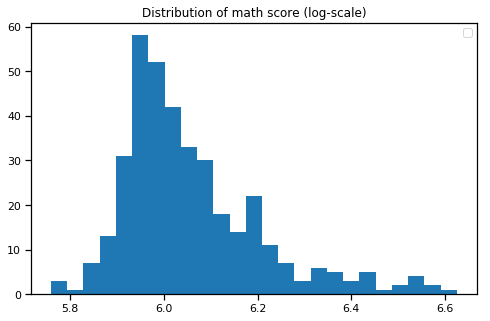

In [47]:
plt.figure(figsize = (8,5))
plt.hist(np.log(df.math), bins = 25)
plt.title("Distribution of math score (log-scale)")
plt.legend()
plt.show()


### Train/Test Split

In [48]:
X = df.drop('math', axis=1)
Y = np.log(df.math)

In [49]:
indices = range(df.shape[0])
i_schools = []
len_ischools = []

In [ ]:
for s in schools:
    i_school = np.where(df.school == s)[0]
    len_ischools.append(len(i_school))
    i_schools.append(i_school)

In [ ]:
min_len = min(len_ischools)
train_size = round(min_len*0.8)

In [ ]:
train_idx = []
test_idx = []

In [ ]:
for s in i_schools:
    np.random.shuffle(s)
    train_idx = np.concatenate((train_idx, s[:train_size]), axis=None)
    test_idx = np.concatenate((test_idx, s[train_size:]), axis=None)

In [ ]:
len(train_idx)

In [ ]:
len(test_idx)

In [ ]:
X_train = X.iloc[train_idx,:]
X_test = X.iloc[test_idx,:].reset_index()
Y_train = Y.iloc[train_idx]
Y_test = Y.iloc[test_idx]

## Pooled model 

In [ ]:
pooled_code = """
data {
    int<lower=0>  N;
    int<lower=0> M;
    vector[N] x;
    vector[M] x_test;
    vector[N] y;
}
parameters {
    vector[2] beta;
    real<lower=0> sigma;
}
model {
    y ~ normal(beta[1] + beta[2]*x, sigma);
}
generated quantities{
    vector[N] log_lik;
    vector[M] y_pred_test;
    for (i in 1:M)
     y_pred_test[i] = normal_rng(beta[1] + beta[2]*x_test[i], sigma);
    for (i in 1:N)
     log_lik[i] = normal_lpdf(y[i]| beta[1] + beta[2]*x[i], sigma);
}

"""

In [ ]:
import pystan

pool_data = {
    'N': Y_train.shape[0], 
    'M': Y_test.shape[0],
    'x': X_train.loc[:,'year_teaching'],
    'x_test': X_test.loc[:,'year_teaching'],
    'y': Y_train,
}

In [ ]:
pooled_fit = pystan.stan(model_code=pooled_code, data = pool_data, iter = 1000, chains = 2)

In [ ]:
print("Rhat check : ",pystan.diagnostics.check_rhat(pooled_fit))
print("N_eff check : ",pystan.diagnostics.check_n_eff(pooled_fit))
print("Divergence check: ", pystan.diagnostics.check_div(pooled_fit))

In [ ]:
pooled_sample = pooled_fit.extract(permuted=True)

loglik = (pooled_sample["log_lik"])
psisloo = stanity.psisloo(loglik)
print("psisloo: ",psisloo.elpd)
psisloo.plot()
lppd_pooled = 0 
for i in range (Y_train.shape[0]):
    lppd_pooled = lppd_pooled + np.log(np.mean(np.exp(loglik[:,i])))

peff_pooled = np.sum(lppd_pooled) - psisloo.elpd
print("p_eff: ", peff_pooled)


In [ ]:
psisloo.print_summary()

In [ ]:
b0, m0 = pooled_sample['beta'].T.mean(1)
plt.scatter(df.year_teaching, np.log(df.math))
xvals = np.linspace(0,30)
plt.plot(xvals, m0*xvals+b0, 'r--')
plt.show()


In [ ]:
#Comparing y_pred with y_test
y_pred = np.mean(pooled_sample["y_pred_test"], axis=0)
plt.hist(y_pred, bins = 15)
round(MAE(Y_test, y_pred),3)

In [ ]:
round(MSE(Y_test, y_pred),3)

##  Separate model

In [ ]:
separate_code = """
data{
    int<lower=0> N;
    int<lower=1, upper=79> school[N]; #school indicator
    vector[N] x;
    vector[N] y;
}
parameters {
    vector[79] alpha;
    real beta; #only 1 beta, not a vector
    real<lower=0> sigma;
}
transformed parameters {
    vector[N] mu;  
    for (i in 1:N)
        mu[i] <- beta* x[i] + alpha[school[i]];
}
model {
    y ~ normal(mu, sigma);
}
generated quantities{
    vector[N] log_lik;
    for (i in 1:N)
     log_lik[i] = normal_lpdf(y[i]| mu[i], sigma);
}
"""

In [ ]:
separate_data = {'N': X_train.shape[0],
                 'school': X_train.school,
                 'x': X_train.loc[:,'year_teaching'],
                 'y': Y_train }

In [ ]:
separate_fit = pystan.stan(model_code = separate_code, data = separate_data, iter = 1000, chains = 2)
separate_sample = separate_fit.extract(permuted=True)

In [ ]:
print("Rhat check : ",pystan.diagnostics.check_rhat(separate_fit))
print("N_eff check : ",pystan.diagnostics.check_n_eff(separate_fit))
print("Divergence check: ", pystan.diagnostics.check_div(separate_fit))

In [ ]:
alpha = np.mean(separate_fit['alpha'], axis=0)
beta = np.mean(separate_fit['beta'])

In [ ]:
loglik = (separate_sample["log_lik"])
psisloo = stanity.psisloo(loglik)
print("psisloo: ",psisloo.elpd)
psisloo.plot()
lppd_pooled = 0 
for i in range (Y_train.shape[0]):
    lppd_pooled = lppd_pooled + np.log(np.mean(np.exp(loglik[:,i])))

peff_pooled = np.sum(lppd_pooled) - psisloo.elpd
print("p_eff: ", peff_pooled)

In [ ]:
psisloo.print_summary()

In [ ]:
Y_pred = []
for i in range(X_test.shape[0]):
    school = X_test.loc[i, 'school']
    Y_pred.append(alpha[school-1] + beta*X_test.loc[i, 'year_teaching'])

plt.hist(y_pred, bins = 15)

In [ ]:
MAE(Y_pred, Y_test)

In [ ]:
MSE(Y_pred, Y_test)

In [ ]:
import seaborn as sns
sns.set(style="ticks")

a_sample = pd.DataFrame(separate_fit['alpha'])
plt.figure(figsize=(14, 5))
sns.boxplot(data=a_sample, whis=np.inf, color="b")
plt.title("Samples of intercept per school")
plt.show()


# Varying intercept and slope model

In [ ]:
varying_intercept_slope = """
data {
  int<lower=0> N;
  int<lower=0> J;
  vector[N] y;
  vector[N] x;
  int school[N];
}
parameters {
  real<lower=0> sigma;
  real<lower=0> sigma_a;
  real<lower=0> sigma_b;
  vector[J] alpha;
  vector[J] beta;
  real mu_a;
  real mu_b;
}
transformed parameters {
    vector[N] mu;  
    for (i in 1:N)
        mu[i] <- alpha[school[i]] + beta[school[i]]*x[i];
}
model {
  mu_a ~ normal(0, 1);
  mu_b ~ normal(0, 1);

  alpha ~ normal(mu_a, sigma_a);
  beta ~ normal(mu_b, sigma_b);
  y ~ normal(mu, sigma);
}

generated quantities{
    vector[N] log_lik;
    for (i in 1:N)
     log_lik[i] = normal_lpdf(y[i]| mu[i], sigma);
}

"""

In [ ]:
varying_intercept_slope_data = {'N': df.shape[0],
                          'J': 79,
                          'school': star.schidkn,
                          'x': df.loc[:,'year_teaching'],
                          'y': np.log(df.math)}

varying_intercept_slope_fit = pystan.stan(model_code=varying_intercept_slope, 
                                          data=varying_intercept_slope_data, 
                                          iter=1000, chains=2)
varying_intercept_slope_sample = varying_intercept_slope_fit.extract(permuted=True)

In [ ]:
print("Rhat check : ",pystan.diagnostics.check_rhat(varying_intercept_slope_fit))
print("N_eff check : ",pystan.diagnostics.check_n_eff(varying_intercept_slope_fit))
print("Divergence check: ", pystan.diagnostics.check_div(varying_intercept_slope_fit))

In [ ]:
sns.set(style="ticks")

a_sample = pd.DataFrame(varying_intercept_slope_sample['alpha'])
plt.figure(figsize=(14, 5))
sns.boxplot(data=a_sample, whis=np.inf, color="b")
plt.title("Samples of intercept per school")
plt.show()

b_sample = pd.DataFrame(varying_intercept_slope_sample['beta'])
plt.figure(figsize=(14, 5))
sns.boxplot(data=b_sample, whis=np.inf, color = 'g')
plt.title("Samples of slope per school")
plt.show()


In [ ]:
xvals = np.arange(2)
b = varying_intercept_slope_fit['alpha'].mean(axis=0)
m = varying_intercept_slope_fit['beta'].mean(axis=0)
plt.figure(figsize=(6,8))
for bi,mi in zip(b,m):
    plt.plot(xvals, mi*xvals + bi, 'bo-', alpha=0.4)
plt.xlim(-0.1, 1.1);

In [ ]:
loglik = (varying_intercept_slope_sample["log_lik"])
psisloo = stanity.psisloo(loglik)
print("psisloo: ",psisloo.elpd)
psisloo.plot()
lppd_pooled = 0 
for i in range (Y_train.shape[0]):
    lppd_pooled = lppd_pooled + np.log(np.mean(np.exp(loglik[:,i])))

peff_pooled = np.sum(lppd_pooled) - psisloo.elpd
print("p_eff: ", peff_pooled)

In [ ]:
psisloo.print_summary()

## Hierarchical model